In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
print("done")

done


In [2]:
class CustomDataset(Dataset):
    def __init__(self, data_csv, target_csv=None, transform=None):
        self.data = pd.read_csv(data_csv, header=None)
        self.targets = pd.read_csv(target_csv, header=None) if target_csv is not None else None
        self.transform = transform

    def __len__(self):
        # return total number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # extract the image data and reshape it to (1, 48, 48) and convert to float 32
        data_path = self.data.iloc[idx].values.astype("float32").reshape(1, 48, 48)
        data = torch.tensor(data_path)

        # apply transformations if specified
        if self.transform:
            data = self.transform(data)

        # retrive target label if not None
        if self.targets is not None:
            target = int(self.targets.iloc[idx, 0])
            return data, target
        else:
            return data

print("done")

done


In [3]:
# transformations to apply on the training data
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # randomly flip images horizontally
    transforms.RandomRotation(10), # rotate images within a range of -10 to +10 degrees
    transforms.Normalize((0.5,), (0.5,))
])

# create a training dataset instance with transformations applied
train_dataset = CustomDataset(
    data_csv='train_data.csv',
    target_csv='train_target.csv',
    transform = train_transforms
)

# create a DataLoader to handle batch processing and random shuffling of the data
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print("done")

done


In [4]:
class FacialExpressionClassifier(nn.Module):
            
    # where we define all the parts of the model
    def __init__(self):
        super().__init__()

        # first convolutional block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2)

        # fully connected lyaers and ReLU activation functions
        self.fc1 = nn.Linear(128*3*3, 64)
        self.act_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.act_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 3)

    # connect the parts of init and return the output
    def forward(self, x):
        # pass through the convolutional layers
        out = self.pool1(self.act1(self.bn1(self.conv1(x))))
        out = self.pool2(self.act2(self.bn2(self.conv2(out))))
        out = self.pool3(self.act3(self.bn3(self.conv3(out))))
        out = self.pool4(self.act4(self.bn4(self.conv4(out))))

        # flatten the output from the last convolutional layer to pass through the fully connected layers
        out = out.view(out.size(0), -1)

        # pass x through the fully connected layers with activation functions
        out = self.act_fc1(self.fc1(out))
        out = self.act_fc2(self.fc2(out))
        out = self.fc3(out)

        # return raw scores for each class
        return out

print("done")

done


In [5]:
# creates an instance of the model
model = FacialExpressionClassifier()

# apply the cross-entropy loss function (typically used for multi-class classification)
criterion = nn.CrossEntropyLoss()

# updates the model's parameters during training
optimizer = optim.Adam(model.parameters(), lr=0.004)

print("done")

done


In [6]:
# specifies how many times the model iterates over the entire training dataset
num_epochs = 80

# list to store average loss for each epoch
losses = []

# iterates over num_epochs
for epoch in range(num_epochs):
    model.train()

    # track cumulative loss for each epoch
    running_loss = 0.0

    # iterates over each mini-batch of images and labels from the train_loader
    for images, labels in train_loader:
        # passes each batch of images trhough the model to generate predictions
        outputs = model(images)

        # computes the loss
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()  # resets gradients before each new batch
        loss.backward()  # computes the gradients of the loss using backpropagation
        optimizer.step()  # update model parameters
        running_loss += loss.item()

    average_loss = running_loss / len(train_loader)

    # store the average loss for plotting
    losses.append(average_loss)

    # print the loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    

Epoch [1/80], Loss: 1.0006
Epoch [2/80], Loss: 0.7703
Epoch [3/80], Loss: 0.6678
Epoch [4/80], Loss: 0.6207
Epoch [5/80], Loss: 0.5846
Epoch [6/80], Loss: 0.5672
Epoch [7/80], Loss: 0.5384
Epoch [8/80], Loss: 0.5205
Epoch [9/80], Loss: 0.5043
Epoch [10/80], Loss: 0.4869
Epoch [11/80], Loss: 0.4726
Epoch [12/80], Loss: 0.4611
Epoch [13/80], Loss: 0.4520
Epoch [14/80], Loss: 0.4297
Epoch [15/80], Loss: 0.4190
Epoch [16/80], Loss: 0.4168
Epoch [17/80], Loss: 0.4044
Epoch [18/80], Loss: 0.3872
Epoch [19/80], Loss: 0.3793
Epoch [20/80], Loss: 0.3669
Epoch [21/80], Loss: 0.3578
Epoch [22/80], Loss: 0.3439
Epoch [23/80], Loss: 0.3386
Epoch [24/80], Loss: 0.3320
Epoch [25/80], Loss: 0.3326
Epoch [26/80], Loss: 0.3093
Epoch [27/80], Loss: 0.3038
Epoch [28/80], Loss: 0.2985
Epoch [29/80], Loss: 0.2893
Epoch [30/80], Loss: 0.2913
Epoch [31/80], Loss: 0.2729
Epoch [32/80], Loss: 0.2768
Epoch [33/80], Loss: 0.2653
Epoch [34/80], Loss: 0.2618
Epoch [35/80], Loss: 0.2515
Epoch [36/80], Loss: 0.2410
E

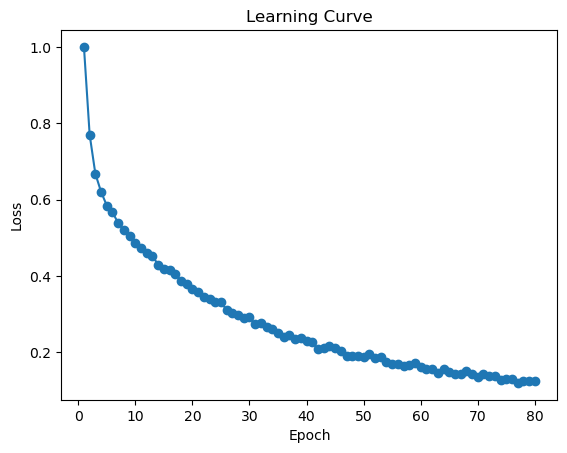

In [7]:
# plot the learning curve for each epoch
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

In [8]:
# transformations to apply on the testing data
test_transforms = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

# create a testing dataset instance with transformations applied
test_dataset = CustomDataset(
    data_csv='test_data.csv',
    transform=test_transforms
)

# create a DataLoader to handle batch processing and random shuffling of the data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# switches model to evaluation mode
model.eval()

predictions = []

# gradients are not needed because we are not updating model parameters
with torch.no_grad():
    # iterates over each batch of images from test_loader
    for images in test_loader:
        outputs = model(images)  # generate raw predictions for each class
        _, predicted = torch.max(outputs, 1)  # get class with highest score
        predictions.extend(predicted.cpu().numpy())  # append each batch's predictions to the predictions list

In [10]:
# converts results into a csv file for submission
submission = pd.DataFrame({
    'Id': range(len(predictions)),  
    'Category': predictions
})

submission.to_csv('submission.csv', index=False)
print("done")



done
